# IRC User Classifier

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph
from irc_utils import compute_score

In [94]:
import os 

project_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/'
# project_dir = '/home/prenek/IRC-Behavioral-Analysis/'
log_dir = os.path.join(project_dir, 'zeek/logs/')
out_dir = os.path.join(project_dir, 'python/out/')


data = pd.read_csv(os.path.join(out_dir, 'irc_user_features_all.csv'))
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()
# # Prepare data for training
# # Divide the data into attributes and labels
X = data.iloc[:, 2:-3]
y = data.iloc[:, -1]

X['lang'] = X['lang'].astype('category').cat.codes
X = X.apply(lambda x: x.fillna(x.mean()),axis=0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

## Experiment 1 - Unbalanced Dataset

Keep the same ratio between the samples when splitting between test/val/trn, no matter how many samples are malicious or benign
- to do this - comment code in experiment 2

In [95]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# print('Original dataset shape %s' % Counter(y))

# ros = RandomOverSampler(random_state=0)
# X, y = ros.fit_resample(X, y)

# print(sorted(Counter(y).items()))


# from imblearn.under_sampling import RandomUnderSampler
# ros = RandomUnderSampler(random_state=0)
# X, y = ros.fit_resample(X, y)
# from collections import Counter
# print(sorted(Counter(y).items()))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

In [96]:
n1 = y.shape[0]
n2 = y[y==0].shape[0]
n3 = y[y==1].shape[0]
# # showing examples of data
print('X: Info - \t Number of samples:\t\t{}\n\t\t Number of benign samples:\t{} \n\t\t Number of malicious samples\t{}\n'.format(n1,n2,n3))

n1 = y_train.shape[0]
n2 = y_train[y_train==0].shape[0]
n3 = y_train[y_train==1].shape[0]
# # showing examples of data
print('X_train: Info -  Number of samples:\t\t{}\n\t\t Number of benign samples:\t{} \n\t\t Number of malicious samples\t{}\n'.format(n1,n2,n3))

n1 = y_test.shape[0]
n2 = y_test[y_test==0].shape[0]
n3 = y_test[y_test==1].shape[0]
# # showing examples of data
print('X_test: Info -  Number of samples:\t\t{}\n\t\t Number of benign samples:\t{} \n\t\t Number of malicious samples\t{}'.format(n1,n2,n3))

X: Info - 	 Number of samples:		582
		 Number of benign samples:	563 
		 Number of malicious samples	19

X_train: Info -  Number of samples:		407
		 Number of benign samples:	394 
		 Number of malicious samples	13

X_test: Info -  Number of samples:		175
		 Number of benign samples:	169 
		 Number of malicious samples	6


In [97]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X = sc.transform(X)

In [98]:
import random
def pick_color(n=1):
    colors = ["blue","black","brown","red","yellow","green","orange","beige","turquoise","pink"]
    random.shuffle(colors)
    return colors[:n]

## PCA

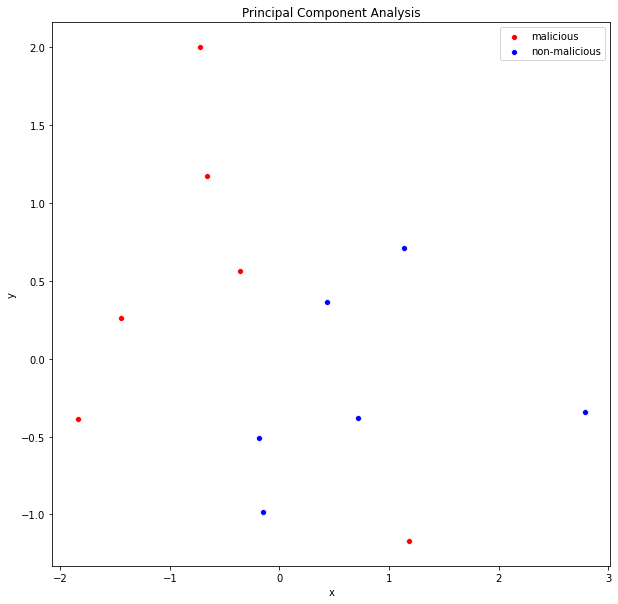

In [16]:
pca = PCA(n_components=2)
_pca = pca.fit(X)
X_pca_train = pca.transform(X_train)
X_pca = _pca.transform(X_test)
lw = 2
# increase fig size when the point annotation is enabled
plt.figure(figsize=(10,10))
plt.title('Principal Component Analysis')
group_offset = 0
for color, i, target_name, alpha in zip(['red','blue'], data.malicious.unique(), ['malicious','non-malicious'], [1, 0.2]):
    _pca_data_x = X_pca[y_test == i, 0]
    _pca_data_y = X_pca[y_test == i, 1]
    _pca_df = pd.DataFrame({
        'x': _pca_data_x,
        'y': _pca_data_y,
        'group': list(range(group_offset, _pca_data_x.shape[0]+group_offset))
    })
    group_offset += _pca_data_x.shape[0]
    
    p1 = sns.scatterplot(x='x',y='y',data=_pca_df, color=color, alpha=1,
                label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

## T-SNE

In [17]:
# 2D
print('t-SNE 2D...')
X_tsne_2d = TSNE(n_components=2,verbose=0).fit_transform(X)
# 3D
print('t-SNE 3D...')
X_tsne_3d = TSNE(n_components=3,verbose=0).fit_transform(X)
print('Done.')

t-SNE 2D...
t-SNE 3D...
Done.


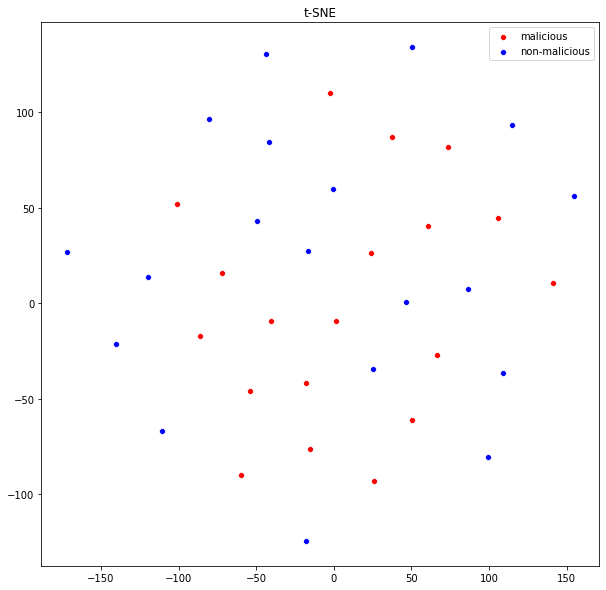

In [18]:
df_tsne_2d = pd.DataFrame({
    'x': X_tsne_2d[:,0],
    'y':X_tsne_2d[:,1],
    'label': y,
    'group': list(range(X_tsne_2d.shape[0]))
})



df_arr = []

for l in data.malicious.unique():
    df_arr.append(df_tsne_2d.where(df_tsne_2d.label==l))

plt.figure(figsize=(10,10))
plt.title('t-SNE')

for df, l, c in zip(df_arr,['malicious','non-malicious'], ["red","blue"]):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

plt.xlabel('')
plt.ylabel('')
plt.show()

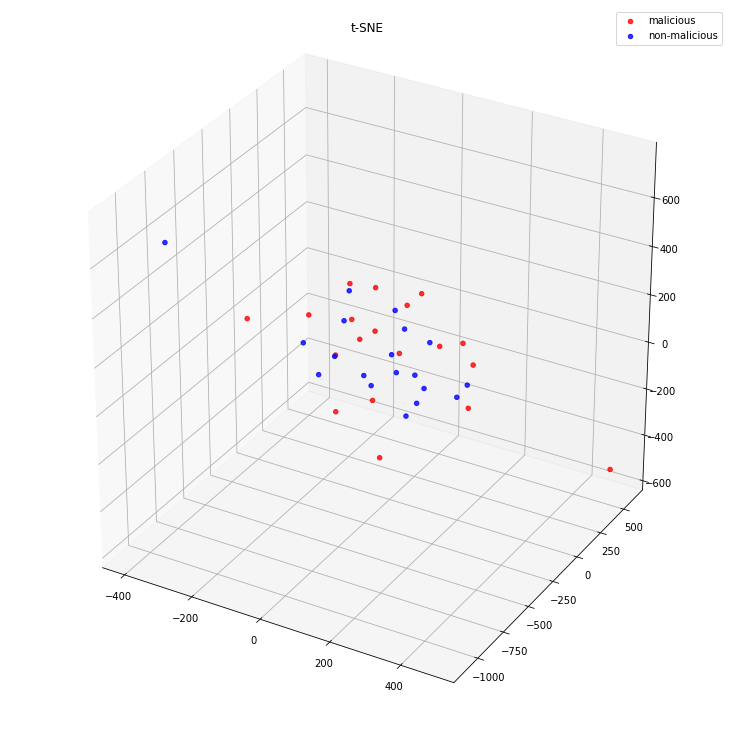

In [19]:
df_tsne_3d = pd.DataFrame({
    'x': X_tsne_3d[:,0],
    'y': X_tsne_3d[:,1],
    'z': X_tsne_3d[:,2],
    'label': y,
    'group': list(range(X_tsne_3d.shape[0]))
})

df_arr = []
for l in data.malicious.unique():
    df_arr.append(df_tsne_3d.where(df_tsne_3d.label==l))

fig = plt.figure(figsize=(10,10))
fig.suptitle('t-SNE')

ax = Axes3D(fig)

for df, l, c in zip(df_arr,['malicious','non-malicious'], ['red','blue']):
    ax.scatter(df.x, df.y, df.z, c=c, marker='o', alpha=0.8, label=l)

ax.legend()
plt.show()

In [20]:
y = y.astype('category').cat.codes
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

## UMAP

### UMAP - Supervised

In [21]:
umap_emb = umap.UMAP(n_neighbors=5).fit_transform(X,y=y)

df_umap = pd.DataFrame({
    'x': umap_emb[:,0],
    'y': umap_emb[:,1],
    'label': y,
    'group': list(range(umap_emb.shape[0]))
})

df_arr = []
for l in y.unique():
    df_arr.append(df_umap.where(df_umap.label==l))

/usr/local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


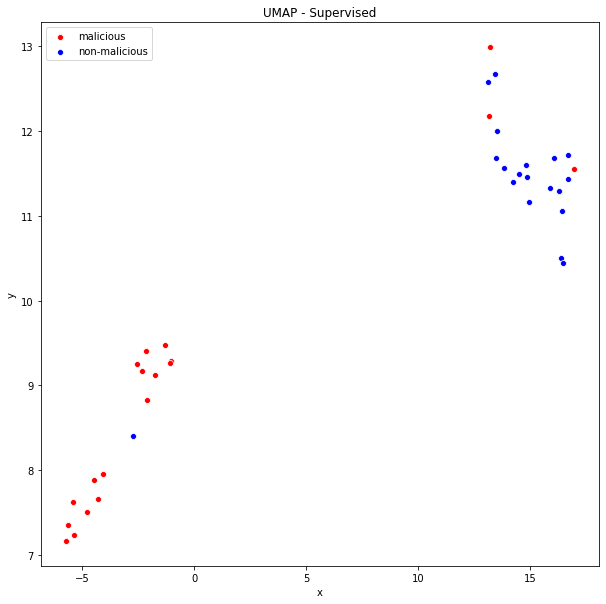

In [22]:
plt.figure(figsize=(10,10))
plt.title('UMAP - Supervised')

for df, l, c in zip(df_arr, ['malicious','non-malicious'], ['red','blue']):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

### UMAP - Unsupervised

In [23]:
umap_emb = umap.UMAP(n_neighbors=5).fit_transform(X)

df_umap = pd.DataFrame({
    'x': umap_emb[:,0],
    'y': umap_emb[:,1],
    'label': y,
    'group': list(range(umap_emb.shape[0]))
})

df_arr = []
for l in y.unique():
    df_arr.append(df_umap.where(df_umap.label==l))

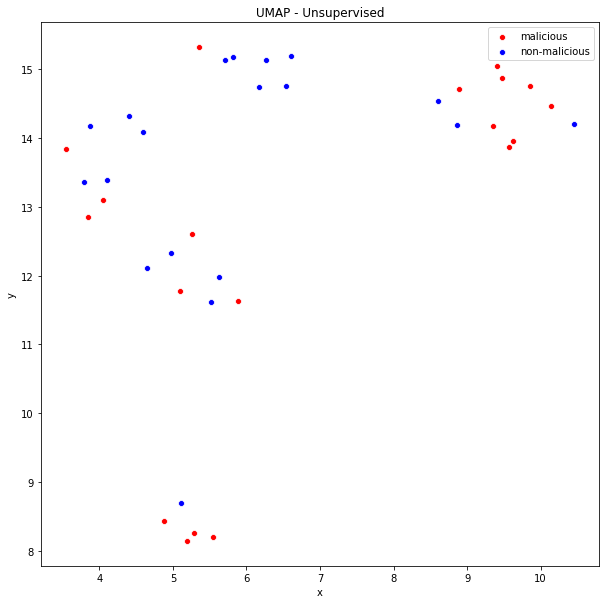

In [24]:
plt.figure(figsize=(10,10))
plt.title('UMAP - Unsupervised')

for df, l, c in zip(df_arr, ['malicious','non-malicious'], ['red','blue']):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

## Unsupervised Learning

### K-Means

In [25]:
sse = []
for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
    km = km.fit(X)
    sse.append(km.inertia_)

print('optimal k is: ', np.argmin(sse))

optimal k is:  13


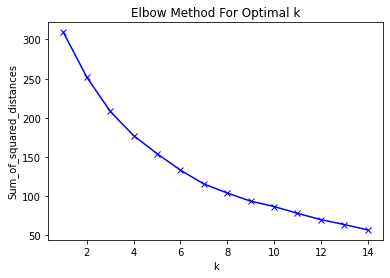

In [26]:
plt.plot(range(1,15), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [99]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(X)
y_pred_kmeans = kmeans.predict(X)

print(compute_score(y, y_pred_kmeans))

Confusion matrix:
[[562   1]
 [ 19   0]]

Sensitivity(=Recall) TPR = TP / (TP + FN):		0.0
Specificity SPC = TN / (FP + TN):			0.9982
Precision PPV = TP / (TP + FP):				0.0
Negative Predictive Value NPV = TN / (TN + FN):		0.9673
False Positive Rate FPR = FP / (FP + TN)):		0.0018
False Discovery rate FDR = FP / (FP + TP):		1.0
False Negative rate FNR = FN / (FN + TP):		1.0
Accuraccy ACC = (TP + TN) / (P + N):			0.9656
F1-score F1 = 2TP / (2TP + FP + FN):			0.0
[0.0, 0.9982, 0.0, 0.9673, 0.0018, 1.0, 1.0, 0.9656, 0.0]


### K-NN

In [82]:
from irc_utils import compute_score
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

print(compute_score(y_test, y_pred_knn))

TypeError: fit() missing 1 required positional argument: 'y'

### Hierarchical Clustering

In [100]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=len(y.unique()), affinity='euclidean', linkage='ward')

y_pred_knn_cluster = cluster.fit_predict(X)


print(compute_score(y,y_pred_knn_cluster))

Confusion matrix:
[[562   1]
 [ 19   0]]

Sensitivity(=Recall) TPR = TP / (TP + FN):		0.0
Specificity SPC = TN / (FP + TN):			0.9982
Precision PPV = TP / (TP + FP):				0.0
Negative Predictive Value NPV = TN / (TN + FN):		0.9673
False Positive Rate FPR = FP / (FP + TN)):		0.0018
False Discovery rate FDR = FP / (FP + TP):		1.0
False Negative rate FNR = FN / (FN + TP):		1.0
Accuraccy ACC = (TP + TN) / (P + N):			0.9656
F1-score F1 = 2TP / (2TP + FP + FN):			0.0
[0.0, 0.9982, 0.0, 0.9673, 0.0018, 1.0, 1.0, 0.9656, 0.0]


# Supervised Learning

## Linear Regression

In [30]:
from sklearn.linear_model import SGDClassifier
# C, kernel, gamma = clf.best_params_['C'], clf.best_params_['kernel'], clf.best_params_['gamma']
linreg = SGDClassifier()

linreg.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
y_pred = linreg.predict(X_test)

print(compute_score(y_test,y_pred))

Confusion matrix:
[[2 4]
 [3 3]]

Sensitivity(=Recall) TPR = TP / (TP + FN):		0.5
Specificity SPC = TN / (FP + TN):			0.3333
Precision PPV = TP / (TP + FP):				0.4286
Negative Predictive Value NPV = TN / (TN + FN):		0.4
False Positive Rate FPR = FP / (FP + TN)):		0.6667
False Discovery rate FDR = FP / (FP + TP):		0.5714
False Negative rate FNR = FN / (FN + TP):		0.5
Accuraccy ACC = (TP + TN) / (P + N):			0.4167
F1-score F1 = 2TP / (2TP + FP + FN):			0.4615
[0.5, 0.3333, 0.4286, 0.4, 0.6667, 0.5714, 0.5, 0.4167, 0.4615]


## Logistic Regression

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20)
    }
]

# Create grid search object
pipe = Pipeline([('classifier' , LogisticRegression())])
clf = GridSearchCV(pipe, scoring='f1', param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)
logreg_model = best_clf.best_params_['classifier']

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished


In [33]:
best_clf.best_params_

{'classifier': LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 4.281332398719396,
 'classifier__penalty': 'l2'}

In [34]:
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)

print(compute_score(y_test,y_pred))

Confusion matrix:
[[3 3]
 [2 4]]

Sensitivity(=Recall) TPR = TP / (TP + FN):		0.6667
Specificity SPC = TN / (FP + TN):			0.5
Precision PPV = TP / (TP + FP):				0.5714
Negative Predictive Value NPV = TN / (TN + FN):		0.6
False Positive Rate FPR = FP / (FP + TN)):		0.5
False Discovery rate FDR = FP / (FP + TP):		0.4286
False Negative rate FNR = FN / (FN + TP):		0.3333
Accuraccy ACC = (TP + TN) / (P + N):			0.5833
F1-score F1 = 2TP / (2TP + FP + FN):			0.6154
[0.6667, 0.5, 0.5714, 0.6, 0.5, 0.4286, 0.3333, 0.5833, 0.6154]


In [35]:
train_ratio = np.arange(0.4,0.95,0.005)
n_samples = len(X)
train_size = []#list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, stratify=y, train_size=trn_ratio, random_state=0)
    train_size.append(len(X_tmp))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tmp, y_tmp, stratify=y_tmp,train_size=0.8, random_state=0)
    logreg = LogisticRegression(C=0.0001, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100, n_jobs=None, penalty='l2', random_state=None, tol=0.0001, verbose=0, warm_start=False)
    logreg.fit(X_train2, y_train2)
    
    y_pred_trn = logreg.predict(X_train2)
    y_pred_tst = logreg.predict(X_test2)
    
    score_trn = f1_score(y_train2, y_pred_trn)
    score_tst = f1_score(y_test2, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)

print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0)
score_tst_list = np.stack(score_tst_list, axis=0)

shape: 110,0.9090909090909091


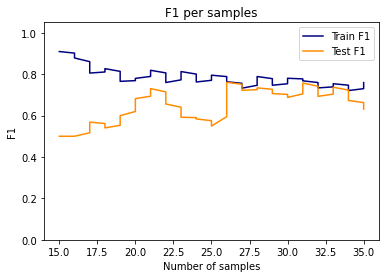

In [36]:
from irc_utils import exponential_moving_average
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0,1.05)
plt.show()

## SVM

In [37]:
from sklearn.svm import SVC

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]


#     print("# Tuning hyper-parameters for %s" % score)
#     print()

clf = GridSearchCV(SVC(C=1), tuned_parameters,scoring='f1',cv=3)
clf.fit(X_train, y_train)

clf.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'sigmoid'}

In [38]:
C, kernel, gamma = clf.best_params_['C'], clf.best_params_['kernel'], clf.best_params_['gamma']
my_svm = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, verbose=True)
my_svm.fit(X_train, y_train)

[LibSVM]

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)

In [39]:
y_pred = my_svm.predict(X_test)

print(compute_score(y_test,y_pred))

Confusion matrix:
[[2 4]
 [2 4]]

Sensitivity(=Recall) TPR = TP / (TP + FN):		0.6667
Specificity SPC = TN / (FP + TN):			0.3333
Precision PPV = TP / (TP + FP):				0.5
Negative Predictive Value NPV = TN / (TN + FN):		0.5
False Positive Rate FPR = FP / (FP + TN)):		0.6667
False Discovery rate FDR = FP / (FP + TP):		0.5
False Negative rate FNR = FN / (FN + TP):		0.3333
Accuraccy ACC = (TP + TN) / (P + N):			0.5
F1-score F1 = 2TP / (2TP + FP + FN):			0.5714
[0.6667, 0.3333, 0.5, 0.5, 0.6667, 0.5, 0.3333, 0.5, 0.5714]


In [40]:
train_ratio = np.arange(0.5,0.95,0.005)
n_samples = len(X)
train_size = []# list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, train_size=trn_ratio, stratify=y, random_state=0)
    train_size.append(len(X_tmp))

    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tmp, y_tmp, stratify=y_tmp, train_size=0.8, random_state=0)
    svc = SVC()
    svc.fit(X_train2, y_train2)
    
    y_pred_trn = svc.predict(X_train2)
    y_pred_tst = svc.predict(X_test2)
    
    score_trn = f1_score(y_train2, y_pred_trn)
    score_tst = f1_score(y_test2, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)

print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0)
score_tst_list = np.stack(score_tst_list, axis=0)

shape: 90,1.0


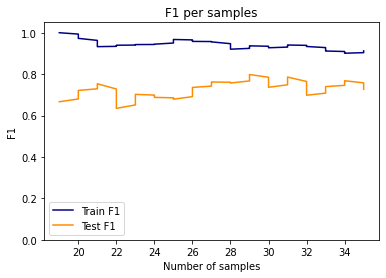

In [41]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0,1.05)
plt.show()

## Random Forrest

In [42]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
param_range = range(1,10)
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train,
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3, scoring='f1')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

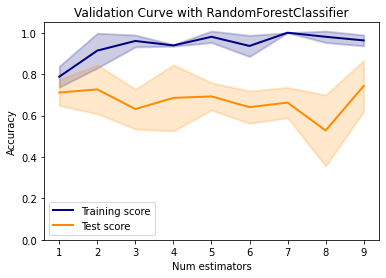

In [43]:
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel('Num estimators')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
              color="navy", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Test score",
              color="darkorange", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.legend(loc="best")
plt.show()

### Exhaustive Grid Search

In [44]:
from sklearn.model_selection import GridSearchCV

n_estimators = [1,5,10,15, 20]
max_depth = [1,2,3,4,5,10]
min_samples_split = [2,3,4,5,10,15,20]
min_samples_leaf = [1,2,3,4,5,10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, n_jobs=-1, scoring='f1')
bestF = gridF.fit(X_train, y_train)
print('''Best parameters: \n
- max_depth: {} \n
- min_samples_leaf: {} \n
- min_samples_split: {} \n
- n_estimators: {}'''.format(bestF.best_params_['max_depth'],
                             bestF.best_params_['min_samples_leaf'],
                             bestF.best_params_['min_samples_split'],
                             bestF.best_params_['n_estimators']))

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   12.0s


Best parameters: 

- max_depth: 5 

- min_samples_leaf: 4 

- min_samples_split: 2 

- n_estimators: 1


[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed:   14.1s finished


In [72]:
max_depth = bestF.best_params_['max_depth']
min_samples_leaf = bestF.best_params_['min_samples_leaf']
min_samples_split = bestF.best_params_['min_samples_split']
n_estimators = bestF.best_params_['n_estimators']

model = RandomForestClassifier(max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [73]:
print(compute_score(y_test,y_pred))

Confusion matrix:
[[5 1]
 [2 3]]

Sensitivity(=Recall) TPR = TP / (TP + FN):		0.6
Specificity SPC = TN / (FP + TN):			0.8333
Precision PPV = TP / (TP + FP):				0.75
Negative Predictive Value NPV = TN / (TN + FN):		0.7143
False Positive Rate FPR = FP / (FP + TN)):		0.1667
False Discovery rate FDR = FP / (FP + TP):		0.25
False Negative rate FNR = FN / (FN + TP):		0.4
Accuraccy ACC = (TP + TN) / (P + N):			0.7273
F1-score F1 = 2TP / (2TP + FP + FN):			0.6667
[0.6, 0.8333, 0.75, 0.7143, 0.1667, 0.25, 0.4, 0.7273, 0.6667]


## Feature Importance

Feature ranking:
1. feature 6 (0.898132)
2. feature 1 (0.101868)
3. feature 9 (0.000000)
4. feature 8 (0.000000)
5. feature 7 (0.000000)
6. feature 5 (0.000000)
7. feature 4 (0.000000)
8. feature 3 (0.000000)
9. feature 2 (0.000000)
10. feature 0 (0.000000)


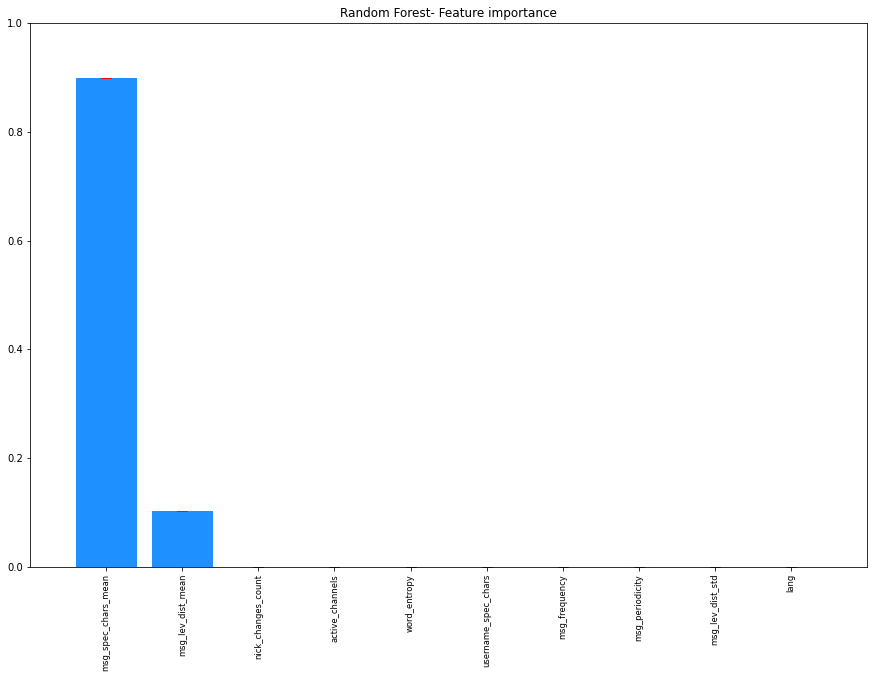

In [75]:
importances = model.feature_importances_
std = np.std([0.3*tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
indices_names = list(map(lambda i: data.columns[i+2], indices))

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure(figsize=(15,10))
plt.title("Random Forest- Feature importance")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="dodgerblue", yerr=std[indices], ecolor='r',capsize=5, align="center")
plt.xticks(range(X_train.shape[1]), indices_names, size='small', rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylim([0,1])
plt.savefig('plot_importances.pdf', format='pdf', bbox_inches='tight')

In [77]:
train_ratio = np.arange(0.5,0.95,0.005)
n_samples = len(X)
train_size = []#list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, stratify=y, train_size=trn_ratio, random_state=0)
    train_size.append(len(X_tmp))
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, stratify=y_tmp, train_size=0.7, random_state=0)
    model = RandomForestClassifier(max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators)
    model.fit(X_train, y_train)
    y_pred_trn = model.predict(X_train)
    y_pred_tst = model.predict(X_test)

    score_trn = f1_score(y_train, y_pred_trn)
    score_tst = f1_score(y_test, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)
    
print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0 )
score_tst_list = np.stack(score_tst_list, axis=0 )

shape: 90,0.7272727272727273


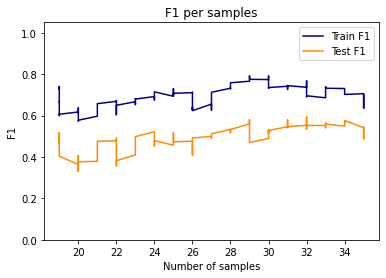

In [78]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0, 1.05)
plt.show()

# XGBoost 

#### Validation curve

In [50]:
import xgboost as xgb
from sklearn.model_selection import validation_curve
param_range = range(1,10)
train_scores, test_scores = validation_curve(
                                xgb.XGBClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', scoring='f1', 
                                param_range = param_range, cv = 3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

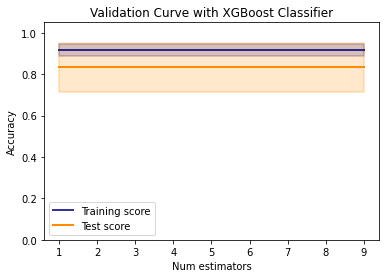

In [51]:
plt.title("Validation Curve with XGBoost Classifier")
plt.xlabel('Num estimators')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
              color="navy", lw=lw, alpha=0.8)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Test score",
              color="darkorange", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.legend(loc="best")
plt.show()

#### Exhaustive Grid Search

In [52]:
from sklearn.model_selection import GridSearchCV

parameters =    {
            'max_depth': [2, 3, 4, 5],
            'n_estimators': [5, 10, 25],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [0, 0.5, 1],
            'colsample_bytree': [0.6, 0.8, 1],
            'reg_alpha': [1e-2, 1e-1, 1e1,10],
            'reg_lambda': [1e-2, 1e-1, 1e1,10],
            }

clf = GridSearchCV(xgb.XGBClassifier(), parameters, scoring = 'f1', cv = 3, verbose = 1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 5184 candidates, totalling 15552 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 11824 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 15552 out of 15552 | elapsed:   15.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'gamma': [0, 0.1, 0.2], 'max_depth': [

In [53]:
clf.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'max_depth': 2,
 'min_child_weight': 0,
 'n_estimators': 10,
 'reg_alpha': 0.01,
 'reg_lambda': 10.0}

In [54]:
p = clf.best_params_

In [55]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=0, max_depth=4,
 min_child_weight=0.5, n_estimators=25, reg_alpha=0.01,reg_lambda=0.1)
xgb_model.fit(X_train, y_train)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [56]:
y_pred = xgb_model.predict(X_test)

print(compute_score(y_test,y_pred))

Confusion matrix:
[[3 2]
 [2 4]]

Sensitivity(=Recall) TPR = TP / (TP + FN):		0.6667
Specificity SPC = TN / (FP + TN):			0.6
Precision PPV = TP / (TP + FP):				0.6667
Negative Predictive Value NPV = TN / (TN + FN):		0.6
False Positive Rate FPR = FP / (FP + TN)):		0.4
False Discovery rate FDR = FP / (FP + TP):		0.3333
False Negative rate FNR = FN / (FN + TP):		0.3333
Accuraccy ACC = (TP + TN) / (P + N):			0.6364
F1-score F1 = 2TP / (2TP + FP + FN):			0.6667
[0.6667, 0.6, 0.6667, 0.6, 0.4, 0.3333, 0.3333, 0.6364, 0.6667]


In [57]:
train_ratio = np.arange(0.5,0.95,0.002)
n_samples = len(X)
train_size = []#list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, stratify=y, train_size=trn_ratio, random_state=0)
    train_size.append(len(X_tmp))
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, stratify=y_tmp, train_size=0.7, random_state=0)
    model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=0, max_depth=2,
 min_child_weight=0.5, n_estimators=5, reg_alpha=0.01,reg_lambda=0.01)
    model.fit(X_train, y_train)
    y_pred_trn = model.predict(X_train)
    y_pred_tst = model.predict(X_test)

    score_trn = f1_score(y_train, y_pred_trn)
    score_tst = f1_score(y_test, y_pred_tst)
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)
    
print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0 )
score_tst_list = np.stack(score_tst_list, axis=0 )

shape: 225,1.0


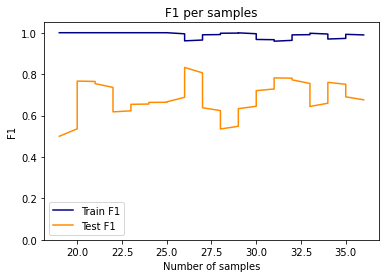

In [58]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0, 1.05)
plt.show()

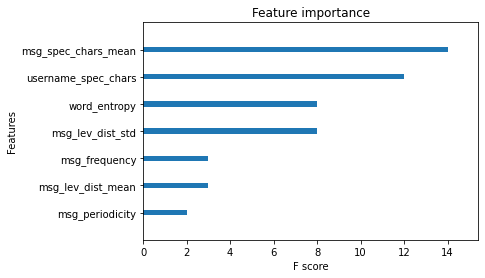

In [59]:
from xgboost import plot_importance
xgb_model.get_booster().feature_names = list(data.columns[2:-3])

plot_importance(xgb_model,grid=False, show_values=False)
plt.show()